# Demanda de Energía Eléctrica y PIB en Colombia: Una aplicación en Python

Uno de los principales retos del análisis macroecónomico es el rezago que se tiene para contar con mediciones precisas del estado de la economía, debido a los procedimientos utilizados para la captura y procesamiento de los datos. Si bien las TICs e iniciativas como la facturación electrónica han contribuido a nivel mundial a solucionar esta situación, el retraso en la medición sigue siendo un problema relevante.

Esto fue especialmente notable durante la situación sanitaria actual donde se requería tener una cuantificación inmediata del impacto económico que los cierres estaban generando.

Tradicionalmente en Colombia la demanda de energía eléctrica ha sido una de las variables más utilizadas para contar con mediciones tempranas del comportamiento de la economía, por lo que en este ejemplo realizaré un pequeño ejercicio econométrico (de poca rigurosidad) acerca de la relación PIB-Demanda Electricidad utilizando técnicas econométricas de cointegración y el Modelos de Corrección de Error.

Por último, este ejercicio se realiza en Python con el fin de ilustrar algunas herramientas menos conocidas del lenguaje para el análisis de series de tiempo las cuales, si bien continúan siendo inferiores a Stata o R, son lo suficientemente robustas para análisis típicos para estos trabajos. Adicionalmente, es importante señalar que esto no es un tutorial en series de tiempo multivariadas sino en el uso de Python para este tipo de análisis, si alguien desea conocer más sobre este tema lo invito a leer los textos de los profesores Lütkepohl y Enders.

Antes de esto los invito a conocer el Estimador Temprano para la Industria Manufacturera que el **DANE** desarrolló con el apoyo del **Equipo de Analítica de XM**, Administrador del Mercado Mayorista de Energía. https://www.dane.gov.co/index.php/estadisticas-por-tema/estadisticas-experimentales

In [335]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import numpy as np

import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.stattools as stt
import statsmodels.tsa.api as tsa
import statsmodels.tsa.vector_ar as vector_ar

### Respecto a los datos utilizados se realizan la siguientes aclaraciones:
1. Se utiliza la Demanda Comercial, Comercial Regulada y Comercial No Regulada publicada por XM a través de la API XM
2. Se utiliza la serie trimestral de PIB Constante publicada por el DANE **sin desestacionalizar**, es decir, se mantienen efectos calendario y temporales

Todos los datos utilizados los pueden encontrar en el repositorio.

### Análisis Visual

Comencemos con la carga de los datos y una inspección visual de estos:

In [336]:
pib = pd.read_excel("pib.xlsx")
pib.set_index('trimestre', inplace=True)

# Agrupamos las demandas diarias por trimestre (Quarter) y la sumamos, es necesario que el índice sea date o datetime

dem_q = pd.read_excel("dem_com.xlsx", index_col='Date').dia.resample('Q').sum() # Demanda Comercial
dem_q_r = pd.read_excel("dem_com_r.xlsx", index_col='Date').dia.resample('Q').sum() # Demanda Comercial Regulada (Residencial + Pequeñas Empresas)
dem_q_n = pd.read_excel("dem_com_n.xlsx", index_col='Date').dia.resample('Q').sum() # Demanda Comercial No Regulada (Grandes Empresas)



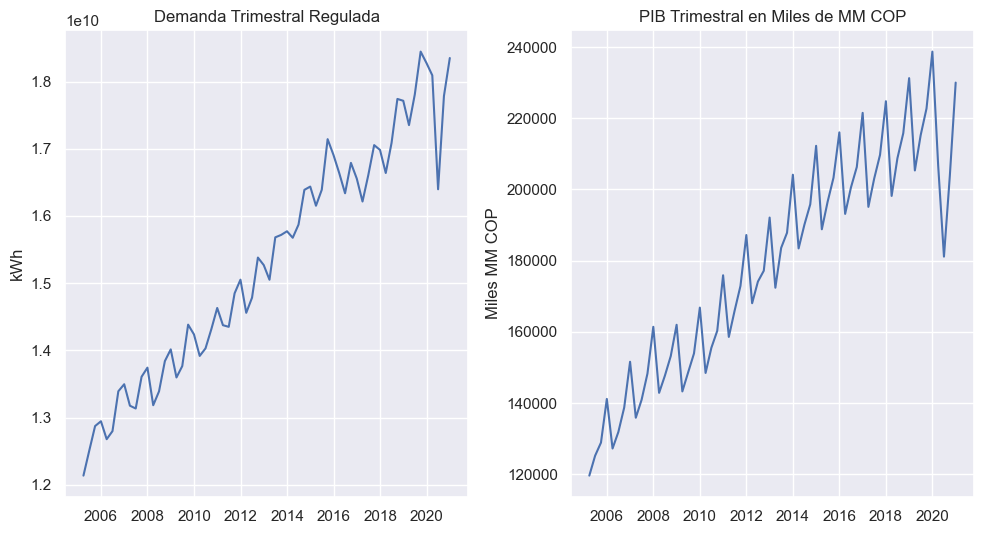

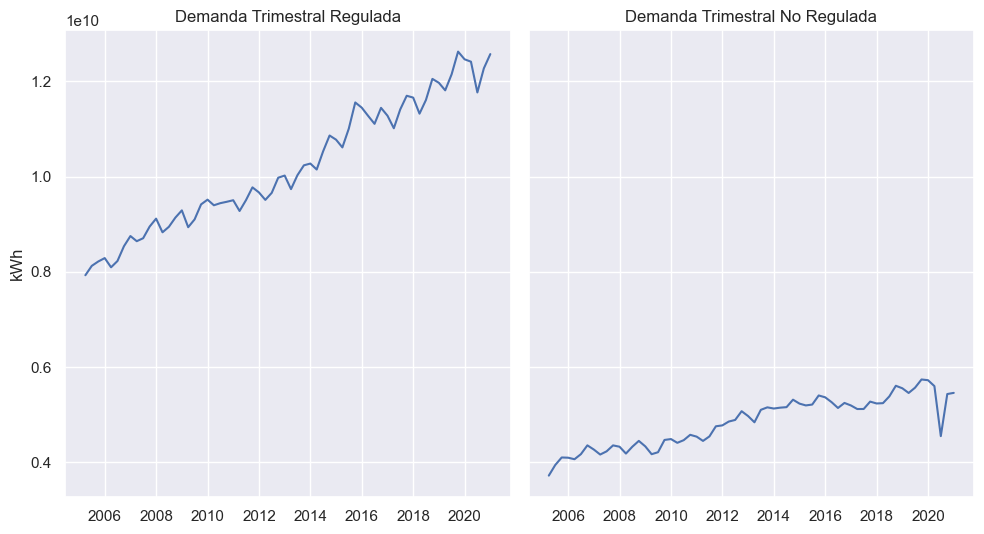

In [340]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10,5.5))

# Demanda Comercial
gDR = sns.lineplot(ax=ax[0], x=dem_q.index, y=dem_q.values, data=dem_q)
gDR.set_title('Demanda Trimestral Regulada')
gDR.set_ylabel('kWh')
gDR.set_xlabel('')

# PIB
gPIB = sns.lineplot(ax=ax[1], x=pib.index, y="miles_mm_cop", data=pib)
gPIB.set_title('PIB Trimestral en Miles de MM COP')
gPIB.set_ylabel('Miles MM COP')
gPIB.set_xlabel('')

fig.tight_layout()

fig, ax2 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5.5))

# Demanda Comercial Regulada
gDR = sns.lineplot(ax=ax2[0], x=dem_q_r.index, y=dem_q_r.values, data=dem_q_r)
gDR.set_title('Demanda Trimestral Regulada')
gDR.set_ylabel('kWh')
gDR.set_xlabel('')

# Demanda Comercial No Regulada
gDR = sns.lineplot(ax=ax2[1], x=dem_q_n.index, y=dem_q_n.values, data=dem_q_n)
gDR.set_title('Demanda Trimestral No Regulada')
gDR.set_ylabel('kWh')
gDR.set_xlabel('')
fig.tight_layout()

A partir de las gráficas se puede ver, como es de esperarse, que la caída en PIB por la pandemia parece estar más correlacionada con el comportamiento de la Demanda No Regulada que la Regulada, sin embargo, se observa también que la tendencia creciente del PIB es similar a la de la demanda regulada.

A continuación vamos a realizar unas pruebas de cointegración para determinar cuál de las tres series de demanda tiene una mayor correlación con la serie del PIB

### Raíz unitaria

Antes de verificar la existencia de cointegración, se debe verificar que las series a analizar tengan raíz unitaria, para esto procedemos a utilizar una de las pruebas más utilizadas: Dickey-Fuller Aumentado, dado el comportamiento de las series se realizará con la inclusión de una tendencia determinística.


In [369]:
adf_pib = stt.adfuller(pib.miles_mm_cop, regression="ct")
adf_dem_q = stt.adfuller(dem_q, regression="ct") # ct: para comparar contra término constante y tendencia
adf_dem_q_r = stt.adfuller(dem_q_r, regression="ct")
adf_dem_q_n = stt.adfuller(dem_q_n, regression="ct")

In [393]:
print('\nValor-p ADF Demanda Comercial: %.3f' % (adf_dem_q[1]))
print('Valor-p ADF Demanda Com NR: %.3f' % (adf_dem_q_n[1]))
print('Valor-p ADF Demanda Com R: %.3f' %(adf_dem_q_r[1]))
print('Valor-p ADF PIB: %.3f' %adf_pib[1])


Valor-p ADF Demanda Comercial: 0.058
Valor-p ADF Demanda Com NR: 0.674
Valor-p ADF Demanda Com R: 0.318
Valor-p ADF PIB: 0.994


A partir de los resultados, vemos que efectivamente el PIB, la Demanda Regulada y la Demanda No Regulada son series no estacionarias, la Demanda Comercial completa (reg + no reg) presenta un valor-p y de estadístico muy cercano al criterio de rechazo, aunque estrictamente hablando no se puede rechazar la hipótesis nula de raíz unitaria con una confianza del 95%

Realicemos una prueba KPSS para tomar una decisión definitiva, en este caso hay que tener en cuenta que la hipótesis nula es la inversa de Dickey-Fuller, es decir, la hipótesis nula **se rechaza** en presencia de raíz unitaria.

Nótese que los estadísticos arrojados por el paquete  para la Demanda Comercial y la Regulada son inferiores al nivel de confianza de 90% por lo que el valor-p **real** es mayor al 10%.

In [394]:
kpss_pib = stt.kpss(pib.miles_mm_cop, regression="ct")
kpss_dem_q = stt.kpss(dem_q, regression="ct") # ct: para comparar contra término constante y tendencia
kpss_dem_q_r = stt.kpss(dem_q_r, regression="ct")
kpss_dem_q_n = stt.kpss(dem_q_n, regression="ct")

print('\nValor-p KPSS Demanda Comercial: %.3f' % (kpss_dem_q[1]))
print('Valor-p KPSS Demanda Com NR: %.3f' % (kpss_dem_q_n[1]))
print('Valor-p KPSS Demanda Com R: %.3f' %(kpss_dem_q_r[1]))
print('Valor-p KPSS PIB: %.3f' %kpss_pib[1])


Valor-p KPSS Demanda Comercial: 0.100
Valor-p KPSS Demanda Com NR: 0.079
Valor-p KPSS Demanda Com R: 0.100
Valor-p KPSS PIB: 0.047


De acuerdo con lo anterior, optamos por asumir como No Estacionaria únicamente la serie de la Demanda No Regulada. La razón para la presencia de características de No Estacionariedad en la *Demanda Regulada* puede ser que, como se dijo al inicio, en esta hay una fracción de la actividad económica que está incluida en dicha agrupación (pequeñas industrias y comercios), sin embargo, dado que la mayoría de la demanda es residencial, esta sigue patrones estables que se pueden representar mediante modelos más sencillos.

### Modelo VEC - Error Correcion Model

In [382]:
aux = pd.merge(pib, dem_q_n, left_index=True, right_index=True)
aux.columns = ['pib', 'demanda']
model = tsa.VAR(endog=aux)
res = model.select_order(8)
res.summary()


,AIC,BIC,FPE,HQIC
0,58.25,58.32,1.976e+25,58.27
1,56.58,56.80,3.746e+24,56.67
2,56.53,56.89,3.548e+24,56.67
3,56.23,56.74,2.646e+24,56.43
4,54.47,55.12,4.572e+23,54.73
5,53.78,54.58*,2.294e+23*,54.09*
6,53.77*,54.72,2.300e+23,54.14
7,53.89,54.97,2.592e+23,54.31
8,53.81,55.04,2.443e+23,54.29


Ahora verificamos la presencia de relaciones de cointegración, aquí es muy importante tener en cuenta si los datos que ingresamos a la prueba están o no transformados (orden de diferenciación y "detrending"). Como en nuestro caso estamos usando los datos *crudos* utilizamos det_order=-1 (no hay *detrending*) y k_ar_diff=0 (no hay diferenciación). Esto es muy importante dado que los resultados cambian radicalmente si no se especifican adecuadamente estos parámetros.

In [197]:
vec_rank = vector_ar.vecm.select_coint_rank(aux, det_order = -1, k_ar_diff = 0, method = 'maxeig', signif=0.01)
print(vec_rank.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          20.46          15.09
  1   2          1.678          6.941
-------------------------------------


Se entiende que hay tantas relaciones de cointegración hasta donde el estadístico sea menor al valor crítico, en este caso 1 dado que 1.678 < 6.941. Recordemos que en los modelos VEC el número máx. de relaciones de cointegración es el número de variables - 1.

Procedemos ahora a especificar nuestro modelo Vector Error Correction

In [395]:
vecm = vector_ar.vecm.VECM(endog = aux, k_ar_diff = 5, coint_rank = 1, deterministic="cili")
vecm_fit = vecm.fit()
forecast, lower, upper = vecm_fit.predict(8, 0.05)

### Diagnóstico de Residuales

Vamos a verificar la presencia de heteroscedasticidad y autocorrelación, para esto usaremos los test de Breusch-Pagan y Durbin-Watson respectivamente.


In [396]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

residuales = pd.DataFrame(vecm_fit.resid)
residuales.columns = ['resid_pib', 'resid_dem_n']

ajustados = pd.DataFrame(vecm_fit.fittedvalues)
ajustados.columns = ['ajustados_pib', 'ajustados_dem_n']

ajustados['trimestre'] = aux.index[6:]
residuales['trimestre'] = aux.index[6:]

ajustados.set_index('trimestre', inplace=True)
residuales.set_index('trimestre', inplace=True)

lm_st, lm_p, f_st, f_p = het_breuschpagan(residuales.resid_pib.values, aux.iloc[6:, :])
dw_p = durbin_watson(residuales.resid_pib)
lj_st, lj_p = sm.stats.acorr_ljungbox(residuales.resid_pib, lags=[5])

In [397]:
print('Pruebas Heteroscedasticidad y Autocorrelación Serial')
print('----------------------------------------------------')
print('\nBreusch-Pagan: %.2f' % lm_p + ' No rechazo H0 (Homoscedasticidad)')
print('\nDurbin-Watson: %.2f' % dw_p + ' >1.55 y < 2.5, no hay evidencia de aucorrelación serial')
print('\nLjung-Box: %.2f' % lj_p + ' valor-p > 0.05, no rechazo H0 (Independencia)')

Pruebas Heteroscedasticidad y Autocorrelación Serial
----------------------------------------------------

Breusch-Pagan: 0.11 No rechazo H0 (Homoscedasticidad)

Durbin-Watson: 2.06 >1.55 y < 2.5, no hay evidencia de aucorrelación serial

Ljung-Box: 0.99 valor-p > 0.05, no rechazo H0 (Independencia)


Una vez verificamos que los residuales cumplen los supuestos distribucionales podemos proceder a realizar el trabajo de inferencia

### Comparación Estimaciones vs. Real

A continuación se presentan los resultados ajustados por el modelo junto con los valores reales

Text(0.5, 0, '')

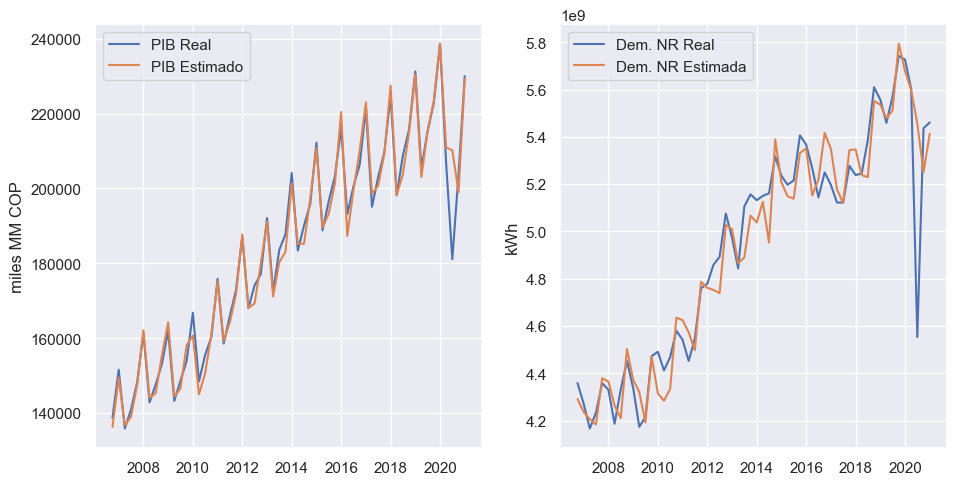

In [330]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(11,5.5))

# PIB
gPIB = sns.lineplot(ax=ax[0], x=aux.index[6:], y=aux.pib[6:], data=aux.iloc[6:, :], label='PIB Real')
gPIB.set_ylabel('miles MM COP')
sns.lineplot(ax=ax[0], x=ajustados.index, y=ajustados.ajustados_pib, data=ajustados, label='PIB Estimado')
gPIB.legend()
gDN = sns.lineplot(ax=ax[1], x=aux.index[6:], y=aux.demanda[6:], data=aux.iloc[6:, :], label='Dem. NR Real')
sns.lineplot(ax=ax[1], x=ajustados.index, y=ajustados.ajustados_dem_n, data=ajustados, label='Dem. NR Estimada')
gDN.set_ylabel('kWh')

gDN.set_xlabel('')
gPIB.set_xlabel('')

### Relaciones de Cointegración

Una de las ventajas de utilizar un modelo VEC en lugar de un VAR tradicional es que, además de contar con la posibilidad de realizar análisis de respuesta al impulso, también se pueden obtener relaciones de corto y largo plazo a partir de la matriz $\pi$

donde:

$\pi = \alpha\beta^T$

$\alpha:$ Relaciones de corto plazo

$\beta:$ Relaciones de largo plazo

En nuestro caso particular como solo tenemos una relación de cointegración sólo hay un beta y corresponde a la siguiente ecuación:
$PIB_t - \beta DemNoReg_t = 0$

De acuerdo con la estimación obtenida

In [392]:
print('Valor Beta en VEC:   '+str(vecm_fit.beta[1][0]))

Valor Beta en VEC:   -6.000504425549318e-05


## ¡¡Importante!!

Los resultados aquí presentados son meramente ilustrativos y **no** representan una investigación exhaustiva de las relaciones de causalidad entre PIB y Demanda de Energía. Lo aquí presentado corresponde únicamente a una introducción al uso de herramientas de series de tiempo múltiples que tiene Python y busca únicamente incentivar su uso asumiendo un conocimiento teórico previo por parte del lector